In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import polarTransform as pt
import fabio

%matplotlib inline

$\phi_0 =  q_0z$

$\tilde{q} = q_0/\lambda_{zz}$ 

$tan(2\phi) = \frac{2\lambda\lambda_{yy}(r-1)\sin(2\tilde{q}z)}{(r-1)(\lambda^2+\lambda_{jj}^2)\cos(2\tilde{q}z)+(r+1)(\lambda^2-\lambda_{jj}^2)}$

$q_0 = $ total initial twist / film thickness

$\lambda_{jj}=\lambda^{-\gamma}$ ... $\gamma$ is $5/7$ analytically for a cholesteric with small stretches ($\lambda-1 << 1$).

Thus, $\lambda_{zz}=\lambda^{\gamma-1}=\lambda^{-\beta}$

See Bermel, Masters thesis, Cambridge University, 2001 or 
https://journals.aps.org/pre/abstract/10.1103/PhysRevE.65.056614

and

https://journals.aps.org/pre/abstract/10.1103/PhysRevE.64.041803

In [2]:
#From an example fit, the last value is c a rotation from the fit.
fit_values = np.array([ 1.23015790e+03, -3.29501995e+03,  5.17866765e+04, -1.28173190e+05,
        1.10284316e+05, -4.09155714e+01])

In [3]:
def ichi(angle,f0,f2,f4,f6,f8,c):
    """
    Intensity($\chi$) equation to fit.
    
    angle: in pi-radians (0-2)
    fn: the coefs from the Legendre expansion
    c: the rotation angle, i.e. misalignment of sample with respect to detector
    See article Mark T. Sims, Laurence C. Abbott, Robert M. Richardson, John W. Goodby &
    John N. Moore (2019) Considerations in the determination of orientational order parameters from X-
    ray scattering experiments, Liquid Crystals, 46:1, 11-24, DOI: 10.1080/02678292.2018.1455227
    """
    angle = angle*np.pi-c
    t1 = f0
    t2 = 0.5*f2*np.cos(angle)**2
    t3 = (3.0/8.0)*f4*np.cos(angle)**4
    t4 = (5.0/16)*f6*np.cos(angle)**6
    t5 = (35.0/128)*f8*np.cos(angle)**8
    return t1+t2+t3+t4+t5

def zero_angles(angles):
    """
    Convert angles to pi-radians and shift to 0.
    """
    zshiftedangles = angles-np.min(angles)
    rads = (2*np.pi)*zshiftedangles/360.0
    return rads/np.pi


Text(0.5, 0, '$\\chi$ ($\\pi$-radians)')

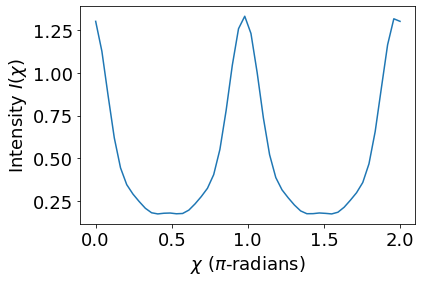

In [4]:
chis = np.linspace(0,2)
norm,normerr = integrate.quad(ichi,0,2,args=tuple(fit_values))
plt.plot(chis,ichi(chis,*fit_values)/norm)

plt.tick_params(which='both',labelsize=18)
plt.ylabel('Intensity $I(\chi)$',size=18)
plt.xlabel(r'$\chi$ ($\pi$-radians)',size=18)

In [5]:
def simulate_xray_warner_model(phis,ffits,bins=360):
    """
    Equation 2.
    phis: is an array of director angles, from front to back of an LCE film
    ffits: is the fit parameters from a uniaxial LCE, including the off axis rotation
    angles: default 360, comes from number of bins in xray data
    """
    intensities = np.zeros(bins)
    chirad = np.linspace(0,2,bins)
    for phi in phis:
        args = tuple(np.append(ffits[:-1],phi))
        intensities += ichi(chirad,*args)
    normts = np.trapz(intensities,chirad)
    #normalized intensity
    return intensities/normts
    
        

In [6]:
def warner_model_phi(z,stretch,init_twist,phi_shift,rval,gamma=5.0/7):
    """
    Implementation of the constitutive model of a stretched cholesteric elastomer.
    Stretched perpendicular to the helix.
    z: 
    stretch: $\lambda$ the stretch
    init_twist: initial total twist
    phi_shift: phi_i or phase of midplane director from 
    r: the parallel/perpendicular step lengths in the polymer network
    gamma: 1-beta, poisson ratio
    """
    film_thickness = np.max(z)-np.min(z)
    lamyy = stretch**(-gamma)
    lamzz = stretch**(gamma-1)
    q_0 = init_twist/film_thickness
    q_tilde = q_0/lamzz
    numerator = 2*stretch*lamyy*(rval-1)*np.sin(2*q_tilde*z+phi_shift)
    denom = (rval-1)*(stretch**2+lamyy**2)*np.cos(2*q_tilde*z+phi_shift)+(rval+1)*(stretch**2-lamyy**2)
    phi = 0.5*np.arctan2(numerator,denom)
    return phi


Text(0.5, 0, '$\\chi$ (degrees)')

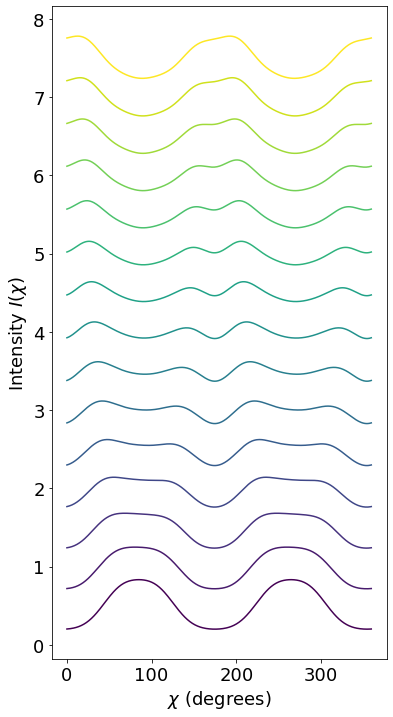

In [7]:
zs = np.linspace(-35,35) # set the thickness of the sample +/- 35 microns
stretches = np.arange(1.0,2.5,0.1) # the quasistatic stretches
init_twist = 80 # initial total twist
colors = plt.cm.viridis(np.linspace(0,1,len(stretches))) # color them

# do the plotting
plt.figure(figsize=(6,12))
for ix,sx in enumerate(stretches):
    # compute the model twist profile - tprof
    tprof = warner_model_phi(zs,sx,np.pi*init_twist/180,170*np.pi/180,rval=np.sqrt(2.5**7))
    # compute what the scattering looks like summed from all the phi(z)
    simrays = simulate_xray_warner_model(tprof,fit_values)
    #plot and offset
    plt.plot(simrays+ix/2.0,color=colors[ix])

plt.tick_params(which='both',labelsize=18)
plt.ylabel('Intensity $I(\chi)$',size=18)
plt.xlabel(r'$\chi$ (degrees)',size=18)

Text(0.5, 0, '$\\chi$ (degrees)')

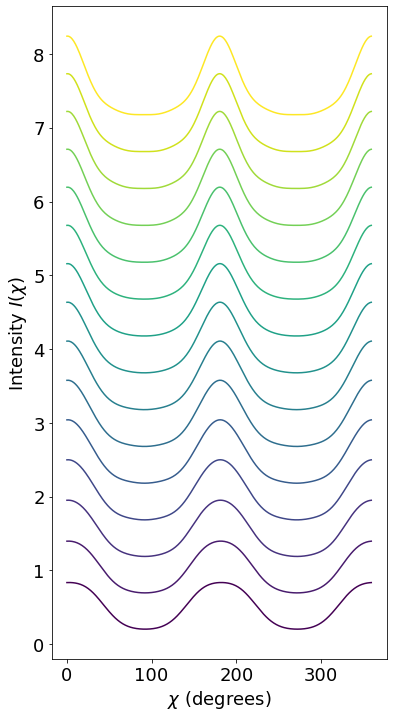

In [8]:
zs = np.linspace(-35,35)
stretches = np.arange(1.0,2.5,0.1)
init_twist = 80
n = len(stretches)
colors = plt.cm.viridis(np.linspace(0,1,n))

plt.figure(figsize=(6,12))

for ix,sx in enumerate(stretches):
    tprof = warner_model_phi(zs,sx,np.pi*init_twist/180,5*np.pi/180,rval=np.sqrt(2.5**7))
    simrays = simulate_xray_warner_model(tprof,fit_values)
    plt.plot(simrays+ix/2.0,color=colors[ix])

plt.tick_params(which='both',labelsize=18)
plt.ylabel('Intensity $I(\chi)$',size=18)
plt.xlabel(r'$\chi$ (degrees)',size=18)